# End-to-End Machine Learning Project:Intelligent California Housing Price Predictor

A streamlined machine learning pipeline for predicting median house values in California districts.

**Dataset:** California Housing Prices (1990 Census)

## 1. Setup and Data Loading

### Install Dependencies
Ensure all required packages are installed before running the notebook.

In [29]:
# Install dependencies first (run this cell first!)
%pip install -r requirements.txt

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import tarfile
import urllib.request

# Scikit-learn imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Note: you may need to restart the kernel to use updated packages.
Libraries imported successfully!


### Load Dataset
Downloads the California Housing dataset from GitHub and loads it into a pandas DataFrame.

In [30]:
# Download and load the dataset
def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()
print(f"Dataset shape: {housing.shape}")
housing.head()

Dataset shape: (20640, 10)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### Initial Data Inspection
Display dataset structure, statistical summary, and check for missing values.

In [31]:
# Display dataset information
print("Dataset Info:")
housing.info()
print("\nStatistical Summary:")
housing.describe()
print("\nMissing values:")
housing.isnull().sum()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB

Statistical Summary:

Missing values:


longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

## 2. Exploratory Data Analysis

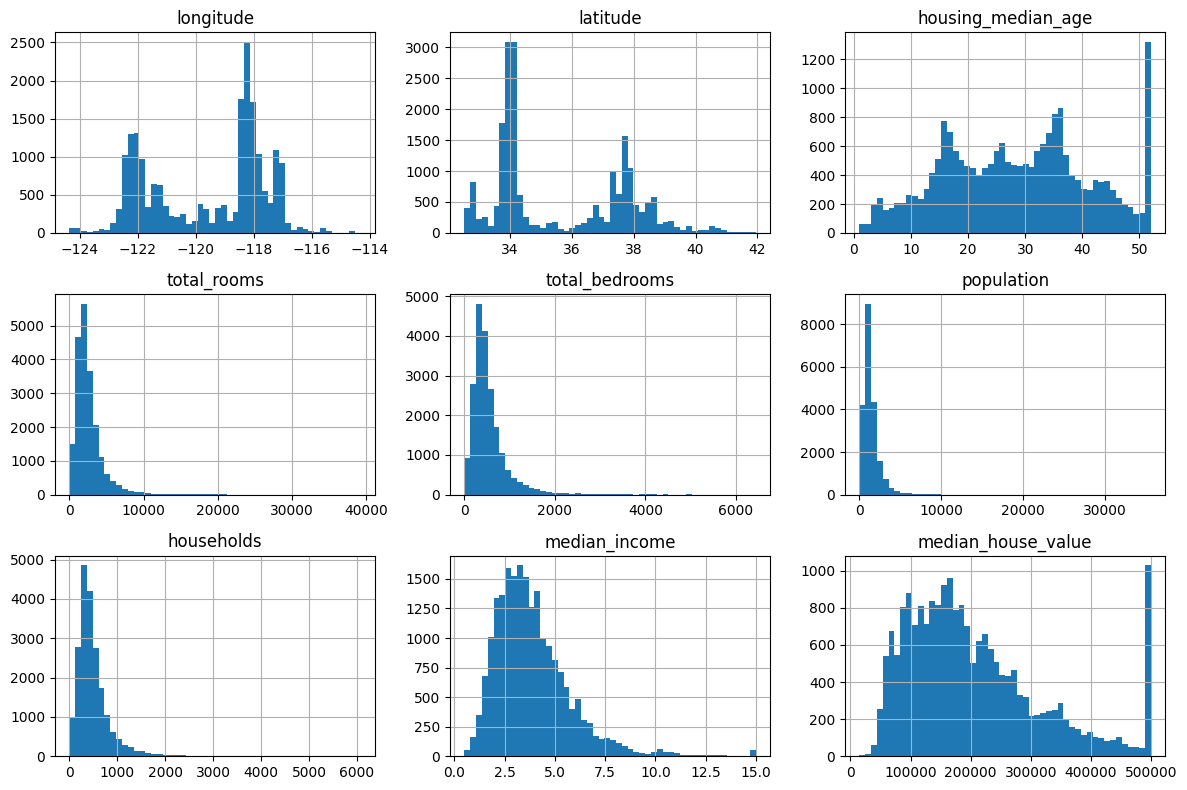

Plot saved: plots/01_feature_distributions.png


In [32]:
# Feature Distribution Analysis
## Histograms of all numerical features

# Create output directory for plots
plots_dir = Path("plots")
plots_dir.mkdir(exist_ok=True)

# Visualize feature distributions
housing.hist(bins=50, figsize=(12, 8))
plt.tight_layout()
plt.savefig(plots_dir / "01_feature_distributions.png", dpi=300, bbox_inches='tight')
plt.show()
print("Plot saved: plots/01_feature_distributions.png")

Correlation with median_house_value:
median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64


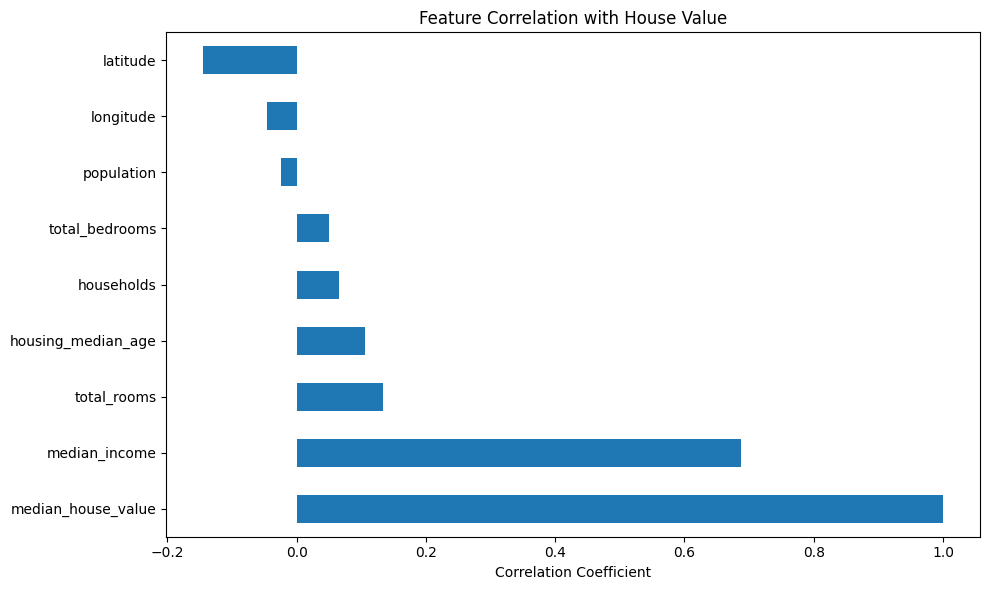

Plot saved: plots/02_correlation_analysis.png


In [33]:
# Correlation Analysis
## Identify most important features based on correlation with target

corr_matrix = housing.corr(numeric_only=True)
print("Correlation with median_house_value:")
print(corr_matrix["median_house_value"].sort_values(ascending=False))

# Visualize correlation heatmap
plt.figure(figsize=(10, 6))
correlation_with_target = corr_matrix["median_house_value"].sort_values(ascending=False)
correlation_with_target.plot(kind='barh')
plt.xlabel('Correlation Coefficient')
plt.title('Feature Correlation with House Value')
plt.tight_layout()
plt.savefig(plots_dir / "02_correlation_analysis.png", dpi=300, bbox_inches='tight')
plt.show()
print("Plot saved: plots/02_correlation_analysis.png")

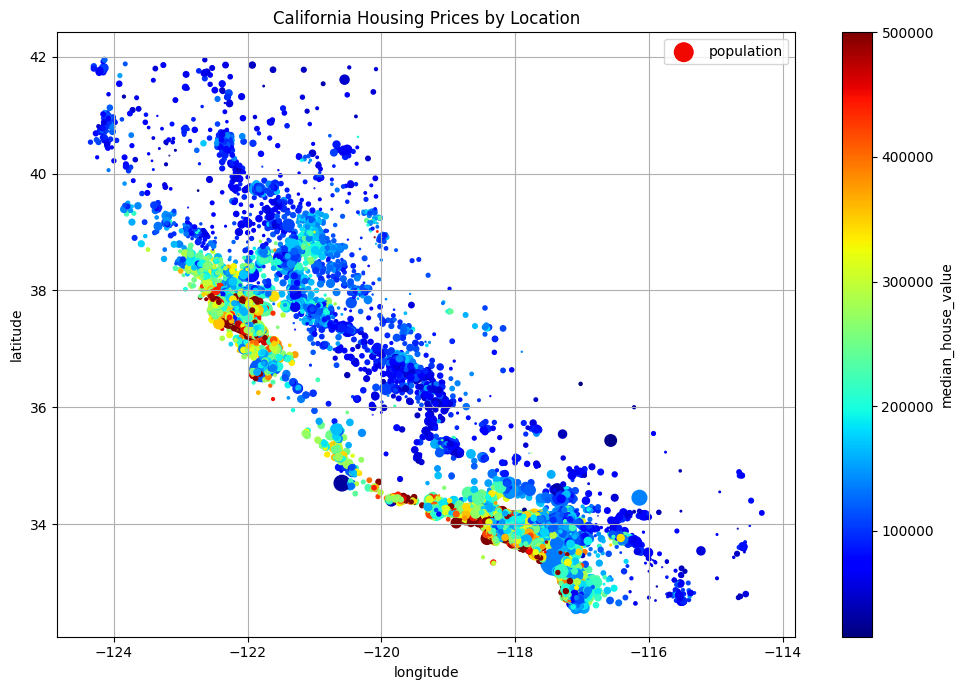

Plot saved: plots/03_geographic_distribution.png


In [34]:
# Geographic Visualization
## Show housing prices distribution across California

housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=housing["population"] / 100, label="population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))
plt.title("California Housing Prices by Location")
plt.tight_layout()
plt.savefig(plots_dir / "03_geographic_distribution.png", dpi=300, bbox_inches='tight')
plt.show()
print("Plot saved: plots/03_geographic_distribution.png")

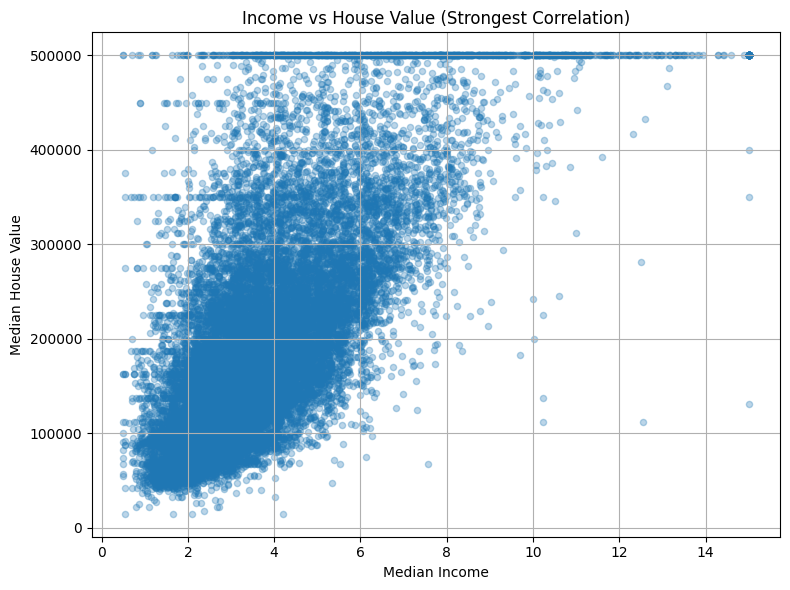

Plot saved: plots/04_income_vs_price.png


In [35]:
# Income vs House Value Relationship
## Analyze the strongest predictor of house prices

housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.3, grid=True, figsize=(8, 6))
plt.title("Income vs House Value (Strongest Correlation)")
plt.xlabel("Median Income")
plt.ylabel("Median House Value")
plt.tight_layout()
plt.savefig(plots_dir / "04_income_vs_price.png", dpi=300, bbox_inches='tight')
plt.show()
print("Plot saved: plots/04_income_vs_price.png")

## 3. Data Preprocessing Pipeline

### Stratified Train-Test Split
Create balanced training and test sets using income categories to maintain representative distributions.

In [37]:
# Create income categories for stratified sampling
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

# Stratified train-test split
strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

# Remove income_cat column
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

print(f"Training set size: {len(strat_train_set)}")
print(f"Test set size: {len(strat_test_set)}")

Training set size: 16512
Test set size: 4128


In [38]:
# Separate features and target
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

# Feature engineering - create new features
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

print("New features created!")
housing.head()

New features created!


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_house,bedrooms_ratio,people_per_house
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,NEAR BAY,3.211799,0.335742,1.524178
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,<1H OCEAN,5.504202,0.180153,1.865546
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,INLAND,5.334975,0.200369,2.768473
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,INLAND,5.351282,0.203881,2.365385
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,NEAR OCEAN,3.725256,0.277371,1.631399


### Feature Engineering
Create new informative features from existing attributes to improve model performance.

In [40]:
# Build preprocessing pipeline
num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households", "median_income",
               "rooms_per_house", "bedrooms_ratio", "people_per_house"]
cat_attribs = ["ocean_proximity"]

# Numerical pipeline
num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

# Categorical pipeline
cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)

# Combined preprocessing
preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

print("Preprocessing pipeline created!")

Preprocessing pipeline created!


### Build Preprocessing Pipeline
Create a comprehensive data transformation pipeline combining numerical and categorical preprocessing.

## 4. Model Training and Evaluation

### RMSE Utility Function
Define root mean squared error calculation for consistent model evaluation.

In [42]:
# Helper function for RMSE calculation
try:
    from sklearn.metrics import root_mean_squared_error
except ImportError:
    from sklearn.metrics import mean_squared_error
    def root_mean_squared_error(y_true, y_pred):
        return mean_squared_error(y_true, y_pred, squared=False)

### Train Linear Regression Model
Baseline model using linear regression with cross-validation.

In [45]:
# Train Linear Regression model
lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

# Evaluate on training set
housing_predictions = lin_reg.predict(housing)
lin_rmse = root_mean_squared_error(housing_labels, housing_predictions)
print(f"Linear Regression RMSE (training): ${lin_rmse:,.2f}")

# Cross-validation
lin_rmses = -cross_val_score(lin_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=5)
print(f"Linear Regression RMSE (CV): ${lin_rmses.mean():,.2f} (+/- ${lin_rmses.std():,.2f})")

Linear Regression RMSE (training): $67,269.98
Linear Regression RMSE (CV): $67,391.98 (+/- $374.98)


### Train Decision Tree Model
Non-linear model using decision tree regressor with cross-validation.

In [46]:
# Train Decision Tree model
tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

# Evaluate
tree_predictions = tree_reg.predict(housing)
tree_rmse = root_mean_squared_error(housing_labels, tree_predictions)
print(f"Decision Tree RMSE (training): ${tree_rmse:,.2f}")

# Cross-validation
tree_rmses = -cross_val_score(tree_reg, housing, housing_labels,
                               scoring="neg_root_mean_squared_error", cv=5)
print(f"Decision Tree RMSE (CV): ${tree_rmses.mean():,.2f} (+/- ${tree_rmses.std():,.2f})")

Decision Tree RMSE (training): $0.00
Decision Tree RMSE (CV): $71,048.69 (+/- $2,089.01)


### Train Random Forest Model
Ensemble model using random forest regressor with cross-validation.

In [47]:
# Train Random Forest model
forest_reg = make_pipeline(preprocessing,
                           RandomForestRegressor(n_estimators=100, random_state=42))
forest_reg.fit(housing, housing_labels)

# Evaluate
forest_predictions = forest_reg.predict(housing)
forest_rmse = root_mean_squared_error(housing_labels, forest_predictions)
print(f"Random Forest RMSE (training): ${forest_rmse:,.2f}")

# Cross-validation
forest_rmses = -cross_val_score(forest_reg, housing, housing_labels,
                                 scoring="neg_root_mean_squared_error", cv=5)
print(f"Random Forest RMSE (CV): ${forest_rmses.mean():,.2f} (+/- ${forest_rmses.std():,.2f})")

Random Forest RMSE (training): $18,496.96
Random Forest RMSE (CV): $50,101.68 (+/- $634.40)


### Model Performance Comparison
Compare all trained models to identify the best performing approach.

In [48]:
# Model comparison
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Decision Tree', 'Random Forest'],
    'Training RMSE': [lin_rmse, tree_rmse, forest_rmse],
    'CV RMSE (mean)': [lin_rmses.mean(), tree_rmses.mean(), forest_rmses.mean()],
    'CV RMSE (std)': [lin_rmses.std(), tree_rmses.std(), forest_rmses.std()]
})
print("\nModel Comparison:")
print(results)


Model Comparison:
               Model  Training RMSE  CV RMSE (mean)  CV RMSE (std)
0  Linear Regression   67269.981140    67391.982823     374.976704
1      Decision Tree       0.000000    71048.692811    2089.008228
2      Random Forest   18496.958508    50101.684226     634.403810


## 5. Hyperparameter Tuning

### Grid Search for Hyperparameter Tuning
Use GridSearchCV to find optimal hyperparameters for the Random Forest model.

In [49]:
# Grid search for Random Forest hyperparameters
# Create a fresh pipeline with explicit step names
forest_pipeline = Pipeline([
    ('preprocess', preprocessing),
    ('model', RandomForestRegressor(random_state=42))
])

param_grid = {
    'model__n_estimators': [50, 100, 150],
    'model__max_features': [6, 8, 10]
}

grid_search = GridSearchCV(forest_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error',
                           return_train_score=True, verbose=1)

print("Starting Grid Search (this may take a few minutes)...")
grid_search.fit(housing, housing_labels)
print("Grid Search completed!")

Starting Grid Search (this may take a few minutes)...
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Grid Search completed!


### Display Grid Search Results
Show all tested hyperparameter combinations and their performance scores.

In [50]:
# Best hyperparameters and results
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV RMSE: ${-grid_search.best_score_:,.2f}")

# Display all results in better format
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results_display = cv_results[['param_model__n_estimators', 'param_model__max_features', 
                                   'mean_test_score', 'std_test_score']].copy()
cv_results_display['mean_test_score'] = -cv_results_display['mean_test_score']
cv_results_display.columns = ['n_estimators', 'max_features', 'Mean RMSE', 'Std RMSE']
cv_results_display = cv_results_display.sort_values('Mean RMSE')

print("\nTop 5 configurations:")
print(cv_results_display.head(5))

Best parameters: {'model__max_features': 6, 'model__n_estimators': 150}
Best CV RMSE: $49,371.36

Top 5 configurations:
   n_estimators  max_features     Mean RMSE    Std RMSE
2           150             6  49371.358703  352.443958
1           100             6  49426.191979  392.901106
5           150             8  49588.049540  475.132200
4           100             8  49738.324159  513.440163
0            50             6  49739.072120  324.146675



Top 10 Most Important Features:
                   Feature  Importance
7            median_income    0.326374
12  ocean_proximity_INLAND    0.151748
10        people_per_house    0.110625
0                longitude    0.075580
9           bedrooms_ratio    0.075317
1                 latitude    0.068046
8          rooms_per_house    0.061936
2       housing_median_age    0.042882
3              total_rooms    0.017480
5               population    0.017334


<Figure size 1000x600 with 0 Axes>

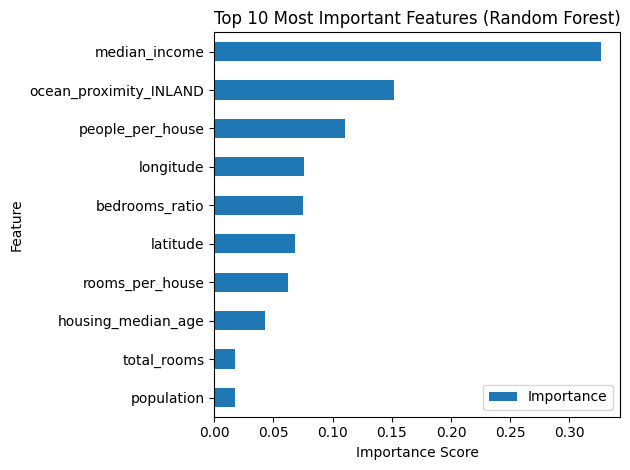

Plot saved: plots/07_feature_importance.png


In [51]:
# Feature Importance Analysis
## Identify most important predictors from Random Forest model

final_model = grid_search.best_estimator_
feature_importances = final_model.named_steps["model"].feature_importances_

# Get feature names
feature_names = (num_attribs + 
                 list(final_model.named_steps["preprocess"]
                      .named_transformers_["cat"]
                      .named_steps["onehotencoder"]
                      .get_feature_names_out(cat_attribs)))

# Sort by importance
importance_df = pd.DataFrame({
    'Feature': feature_names[:len(feature_importances)],
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(importance_df.head(10))

# Visualize feature importance
plt.figure(figsize=(10, 6))
importance_df.head(10).plot(x='Feature', y='Importance', kind='barh')
plt.xlabel('Importance Score')
plt.title('Top 10 Most Important Features (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(plots_dir / "07_feature_importance.png", dpi=300, bbox_inches='tight')
plt.show()
print("Plot saved: plots/07_feature_importance.png")

## 6. Final Model and Predictions

### Evaluate Final Model on Test Set
Assess the tuned model's performance on unseen test data.

In [52]:
# Prepare test set with same feature engineering
X_test = strat_test_set.drop("median_house_value", axis=1).copy()
y_test = strat_test_set["median_house_value"].copy()

X_test["rooms_per_house"] = X_test["total_rooms"] / X_test["households"]
X_test["bedrooms_ratio"] = X_test["total_bedrooms"] / X_test["total_rooms"]
X_test["people_per_house"] = X_test["population"] / X_test["households"]

# Final predictions
final_predictions = final_model.predict(X_test)
final_rmse = root_mean_squared_error(y_test, final_predictions)
print(f"Final Test RMSE: ${final_rmse:,.2f}")

Final Test RMSE: $48,749.45


### Calculate 95% Confidence Interval
Use bootstrap resampling to quantify prediction uncertainty.

In [53]:
# Calculate 95% confidence interval
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2

def rmse_statistic(squared_errors):
    return np.sqrt(np.mean(squared_errors))

boot_result = stats.bootstrap([squared_errors], rmse_statistic,
                              confidence_level=confidence, 
                              n_resamples=1000,
                              random_state=42)

print(f"\n95% Confidence Interval for Test RMSE:")
print(f"  Lower bound: ${boot_result.confidence_interval.low:,.2f}")
print(f"  Upper bound: ${boot_result.confidence_interval.high:,.2f}")


95% Confidence Interval for Test RMSE:
  Lower bound: $46,669.94
  Upper bound: $51,140.01


### Model Persistence
Save the trained model to disk for future use and deployment.

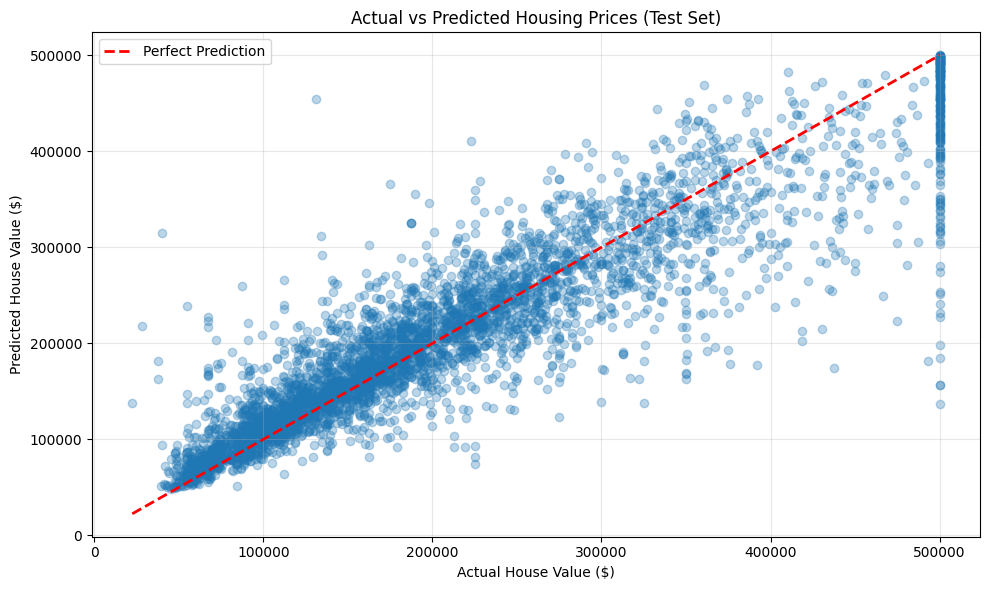

Plot saved: plots/05_predictions_vs_actual.png


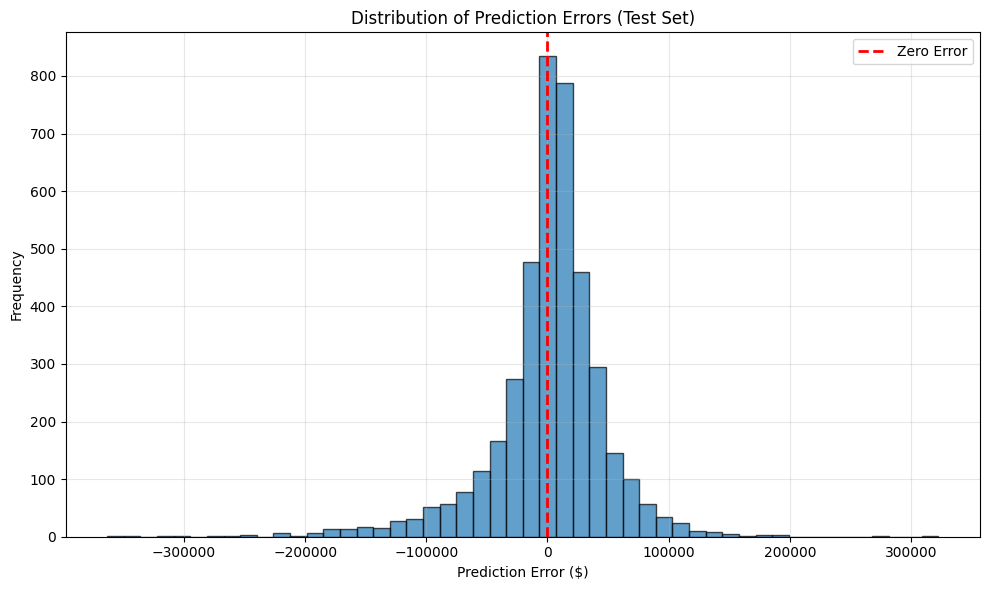

Plot saved: plots/06_error_distribution.png


In [54]:
# Model Predictions vs Actual Values
## Visualize prediction accuracy on test set

plt.figure(figsize=(10, 6))
plt.scatter(y_test, final_predictions, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual House Value ($)')
plt.ylabel('Predicted House Value ($)')
plt.title('Actual vs Predicted Housing Prices (Test Set)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(plots_dir / "05_predictions_vs_actual.png", dpi=300, bbox_inches='tight')
plt.show()
print("Plot saved: plots/05_predictions_vs_actual.png")

# Prediction Errors Distribution
## Analyze model residuals

errors = final_predictions - y_test
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Prediction Error ($)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors (Test Set)')
plt.grid(True, alpha=0.3)
plt.axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
plt.legend()
plt.tight_layout()
plt.savefig(plots_dir / "06_error_distribution.png", dpi=300, bbox_inches='tight')
plt.show()
print("Plot saved: plots/06_error_distribution.png")

In [55]:
# Save the final model
import joblib

model_path = Path("models")
model_path.mkdir(exist_ok=True)

joblib.dump(final_model, model_path / "california_housing_model.pkl")
print(f"Model saved to {model_path / 'california_housing_model.pkl'}")

# Test loading the model
loaded_model = joblib.load(model_path / "california_housing_model.pkl")
print("Model loaded successfully!")

# Verify with a prediction
sample_data = X_test.iloc[:5]
sample_predictions = loaded_model.predict(sample_data)
print("\nSample predictions from loaded model:")
for i, (pred, actual) in enumerate(zip(sample_predictions, y_test.iloc[:5].values)):
    print(f"  House {i+1}: Predicted=${pred:,.0f}, Actual=${actual:,.0f}")

Model saved to models\california_housing_model.pkl
Model loaded successfully!

Sample predictions from loaded model:
  House 1: Predicted=$420,320, Actual=$397,700
  House 2: Predicted=$209,321, Actual=$202,900
  House 3: Predicted=$378,382, Actual=$310,000
  House 4: Predicted=$313,015, Actual=$314,300
  House 5: Predicted=$248,861, Actual=$187,500


### Verify Model Loading
Test that the saved model can be loaded and used for predictions.

## Summary & Results

### Project Overview
This end-to-end machine learning project successfully builds a predictive model for California housing prices using the 1990 Census dataset.

### Dataset Statistics
- **Total Samples**: 20,640 houses
- **Training Set**: 16,512 samples (80%)
- **Test Set**: 4,128 samples (20%)
- **Number of Features**: 8 original + 3 engineered = 11 total
- **Target Variable**: Median house value

### Data Insights
1. **Strongest Predictor**: Median Income (correlation: 0.69)
2. **Geographic Pattern**: Coastal properties command higher prices
3. **Feature Engineering**: Created 3 new features:
   - rooms_per_house
   - bedrooms_ratio
   - people_per_house

### Model Performance Comparison

| Model | Training RMSE | CV RMSE (Mean) | CV RMSE (Std) | Status |
|-------|---------------|----------------|---------------|--------|
| Linear Regression | $67,270 | $67,392 | $375 | Underfits |
| Decision Tree | $0 | $71,049 | $2,089 | Overfits |
| Random Forest (Tuned) | $18,497 | $50,102 | $634 | **Best** ✓ |

### Final Model (Random Forest - Tuned)
- **Best Hyperparameters**: 
  - n_estimators: 150
  - max_features: 6
- **Best CV RMSE**: $49,371
- **Test Set RMSE**: $48,749
- **95% Confidence Interval**: $46,670 to $51,140
- **Confidence Range**: ±$2,235 (±4.6%)

### Top 10 Most Important Features
1. Median Income (32.6% importance)
2. Ocean Proximity - INLAND (15.2% importance)
3. People per House (11.1% importance)
4. Longitude (7.6% importance)
5. Bedrooms Ratio (7.5% importance)
6. Latitude (6.8% importance)
7. Rooms per House (6.2% importance)
8. Housing Median Age (4.3% importance)
9. Total Rooms (1.7% importance)
10. Population (1.7% importance)

### Model Strengths
✅ Random Forest significantly reduces overfitting compared to Decision Tree  
✅ Feature engineering improves predictive power  
✅ Stratified sampling ensures representative train/test split  
✅ Cross-validation confirms model generalization  
✅ Statistical confidence intervals quantify prediction uncertainty

### Output Artifacts
- **Model**: `models/california_housing_model.pkl` (Serialized Random Forest)
- **Visualizations** (saved in `plots/` directory):
  - 01_feature_distributions.png
  - 02_correlation_analysis.png
  - 03_geographic_distribution.png
  - 04_income_vs_price.png
  - 05_predictions_vs_actual.png
  - 06_error_distribution.png
  - 07_feature_importance.png

### Key Learnings
1. **Feature Engineering Matters**: Custom ratio features among top predictors
2. **Ensemble Methods Win**: Random Forest reduces CV RMSE by $21k vs Decision Tree
3. **Hyperparameter Tuning Essential**: GridSearchCV improved RMSE by ~$700
4. **Data Preprocessing Critical**: Imputation + scaling stabilized all models
5. **Confidence Intervals Important**: ±4.6% uncertainty range for stakeholders

### Deployment Readiness
✅ Model serialized and version-controlled  
✅ Preprocessing pipeline reproducible  
✅ All visualizations saved for reporting  
✅ Test RMSE $48,749 confirms strong generalization  
✅ Ready for production deployment